## Assignment 4 - Group 4

#### Question 1: Classification : Fully-connected and Recurrent networks (LSTM)


##### Importing the libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore') 
from sklearn.model_selection import train_test_split,cross_val_score

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import time

In [43]:
#Setting the random seeds to control the randomness each time the model is run
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

### 1.1 [CM1]: Design and Implementation

### Data Loading, Preprocessing  and Analysis

In [44]:
df = pd.read_csv('COVID_dataset.csv',delimiter=',', error_bad_lines=False, warn_bad_lines=True)
df

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,70s,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,50s,FEMALE,NO KNOWN EPI LINK,Newmarket,NaN,44.048023,-79.480239,Not Resolved
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,70s,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Resolved
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,<20,MALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,60s,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved
...,...,...,...,...,...,...,...,...,...,...,...,...
14855,2020-04-02,2020-04-03,2020-04-04,2020-04-02,90s,FEMALE,NO KNOWN EPI LINK,Whitby,NaN,43.898605,-78.940341,Fatal
14856,2021-01-25,2021-01-26,2021-01-26,2021-01-25,<20,MALE,CC,Thorold,NaN,43.116537,-79.241220,Not Resolved
14857,2020-12-07,2020-12-08,2020-12-08,2020-12-07,40s,FEMALE,CC,Mississauga,NaN,43.647471,-79.708893,Resolved
14858,2020-11-22,2020-11-24,2020-11-24,2020-11-22,20s,UNSPECIFIED,CC,Newmarket,NaN,44.048023,-79.480239,Resolved


In [45]:
df.nunique()

Accurate_Episode_Date      332
Case_Reported_Date         323
Test_Reported_Date         320
Specimen_Date              324
Age_Group                    9
Client_Gender                4
Case_AcquisitionInfo         6
Reporting_PHU_City          34
Outbreak_Related             1
Reporting_PHU_Latitude      34
Reporting_PHU_Longitude     34
Outcome1                     3
dtype: int64

In [46]:
df['Client_Gender'].value_counts()

FEMALE            7562
MALE              7192
UNSPECIFIED        105
GENDER DIVERSE       1
Name: Client_Gender, dtype: int64

In [47]:
df.isnull().sum()

Accurate_Episode_Date         0
Case_Reported_Date            0
Test_Reported_Date          203
Specimen_Date               122
Age_Group                     5
Client_Gender                 0
Case_AcquisitionInfo          0
Reporting_PHU_City            0
Outbreak_Related           9082
Reporting_PHU_Latitude        0
Reporting_PHU_Longitude       0
Outcome1                      0
dtype: int64

We see there are missing values in the columns "Test_Reported_Date", "Specimen_Date", "Age_Group" and "Outbreak_Related".

We are replacing those missing values in the colum "Outbreak_Related" with "No".

In [48]:
df['Outbreak_Related'].replace(np.nan, 'No',inplace=True)
df[df['Age_Group'].isnull()]

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
5659,2021-01-21,2021-01-21,NaN,NaN,NaN,FEMALE,OB,Sudbury,No,46.466092,-80.998059,Not Resolved
6709,2020-12-21,2020-12-21,NaN,NaN,NaN,UNSPECIFIED,NO KNOWN EPI LINK,Windsor,No,42.308796,-83.033670,Fatal
9721,2020-12-27,2020-12-31,2020-12-31,2020-12-27,NaN,FEMALE,OB,Kenora,Yes,49.769615,-94.488254,Resolved
10658,2021-01-24,2021-01-24,NaN,NaN,NaN,UNSPECIFIED,NO KNOWN EPI LINK,Simcoe,No,42.847825,-80.303815,Not Resolved
12316,2021-01-30,2021-01-30,NaN,NaN,NaN,FEMALE,MISSING INFORMATION,Peterborough,No,44.301632,-78.321347,Not Resolved


Above are rows in the data where column "Age_Group" is missing. We are replacing the missing value with the mode of the same column corresponding to a particular "Client_Gender".

In [49]:
df[['Client_Gender','Age_Group']].value_counts()
df_female = df[df.Client_Gender=='FEMALE']
df_female['Age_Group'].fillna('90s',inplace = True)
df_unsp = df[df.Client_Gender=='UNSPECIFIED']
df_unsp['Age_Group'].fillna('80s',inplace = True)
df_gd = df[df.Client_Gender=='GENDER DIVERSE']
df_male = df[df.Client_Gender=='MALE']
df_final = df_male.append([df_gd,df_unsp,df_female])
df_final.shape

(14860, 12)

In [50]:
#Formatting the values of "Age_Group" as appropriate.

df_final["Age_Group"].replace({"90s": 90, "80s": 80,"70s": 70, "60s": 60,"50s": 50, "40s": 40,"30s": 30, "20s": 20, "<20": 19 }, inplace=True)
df_final

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,70,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,19,MALE,CC,Mississauga,No,43.647471,-79.708893,Not Resolved
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,60,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved
6,2021-01-23,2021-01-24,2021-01-24,2021-01-23,20,MALE,MISSING INFORMATION,Ottawa,No,45.345665,-75.763912,Not Resolved
8,2021-01-25,2021-01-29,2021-01-29,2021-01-28,40,MALE,CC,Newmarket,No,44.048023,-79.480239,Not Resolved
...,...,...,...,...,...,...,...,...,...,...,...,...
14849,2020-05-10,2020-05-10,2020-05-10,2020-05-08,70,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Fatal
14852,2021-01-20,2021-01-21,2021-01-21,2021-01-20,50,FEMALE,CC,Mississauga,No,43.647471,-79.708893,Not Resolved
14854,2020-04-05,2020-04-05,2020-04-06,2020-04-05,50,FEMALE,OB,St. Thomas,Yes,42.777804,-81.151156,Resolved
14855,2020-04-02,2020-04-03,2020-04-04,2020-04-02,90,FEMALE,NO KNOWN EPI LINK,Whitby,No,43.898605,-78.940341,Fatal


Dropping the date columns "Test_Reported_Date" and "Specimen_Date" from the dataset since these columns have too many null values.

Converting the date columns "Accurate_Episode_Date" and "Case_Reported_Date" into integers.

In [51]:
dataset_wo_dates=df_final.copy()
dataset_wo_dates.drop(dataset_wo_dates.columns[[2,3]], axis = 1, inplace = True)
dataset_wo_dates['Case_Reported_Date'] = pd.to_datetime(df['Case_Reported_Date'])
dataset_wo_dates['Accurate_Episode_Date'] = pd.to_datetime(df['Accurate_Episode_Date'])
dataset_wo_dates['Accurate_Episode_Date'] = dataset_wo_dates['Accurate_Episode_Date'].astype(np.int64)
dataset_wo_dates['Case_Reported_Date'] = dataset_wo_dates['Case_Reported_Date'].astype(np.int64)
dataset_wo_dates

,Accurate_Episode_Date,Case_Reported_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,1585526400000000000,1585612800000000000,70,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
3,1610928000000000000,1611187200000000000,19,MALE,CC,Mississauga,No,43.647471,-79.708893,Not Resolved
4,1608940800000000000,1609113600000000000,60,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved
6,1611360000000000000,1611446400000000000,20,MALE,MISSING INFORMATION,Ottawa,No,45.345665,-75.763912,Not Resolved
8,1611532800000000000,1611878400000000000,40,MALE,CC,Newmarket,No,44.048023,-79.480239,Not Resolved
...,...,...,...,...,...,...,...,...,...,...
14849,1589068800000000000,1589068800000000000,70,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Fatal
14852,1611100800000000000,1611187200000000000,50,FEMALE,CC,Mississauga,No,43.647471,-79.708893,Not Resolved
14854,1586044800000000000,1586044800000000000,50,FEMALE,OB,St. Thomas,Yes,42.777804,-81.151156,Resolved
14855,1585785600000000000,1585872000000000000,90,FEMALE,NO KNOWN EPI LINK,Whitby,No,43.898605,-78.940341,Fatal


Performing one hot encoding for the columns 'Client_Gender', 'Reporting_PHU_City','Case_AcquisitionInfo', 'Outbreak_Related'

In [52]:
dataset = pd.get_dummies(dataset_wo_dates, columns = ['Client_Gender', 'Reporting_PHU_City','Case_AcquisitionInfo', 'Outbreak_Related'])
dataset

,Accurate_Episode_Date,Case_Reported_Date,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1,Client_Gender_FEMALE,Client_Gender_GENDER DIVERSE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,...,Reporting_PHU_City_Whitby,Reporting_PHU_City_Windsor,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL,Case_AcquisitionInfo_UNSPECIFIED EPI LINK,Outbreak_Related_No,Outbreak_Related_Yes
0,1585526400000000000,1585612800000000000,70,43.368662,-81.001913,Fatal,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,1610928000000000000,1611187200000000000,19,43.647471,-79.708893,Not Resolved,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,1608940800000000000,1609113600000000000,60,42.308796,-83.033670,Resolved,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
6,1611360000000000000,1611446400000000000,20,45.345665,-75.763912,Not Resolved,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
8,1611532800000000000,1611878400000000000,40,44.048023,-79.480239,Not Resolved,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14849,1589068800000000000,1589068800000000000,70,43.656591,-79.379358,Fatal,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
14852,1611100800000000000,1611187200000000000,50,43.647471,-79.708893,Not Resolved,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
14854,1586044800000000000,1586044800000000000,50,42.777804,-81.151156,Resolved,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
14855,1585785600000000000,1585872000000000000,90,43.898605,-78.940341,Fatal,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [53]:
target=["Outcome1"]
cols=[col for col in dataset.columns if col not in target]

x=dataset[cols]
y2=dataset[target]

# Normalizing all the columns using StandardScaler()
ss = StandardScaler()
X = ss.fit_transform(x)
y = pd.get_dummies(dataset['Outcome1']).values
print(X.shape, y.shape)

(14860, 51) (14860, 3)


In [54]:
#Splitting the data into train, validation, and test sets (80%, 10%, 10%)

train_valid_x, test_x, train_valid_y, test_y = train_test_split(X, y, test_size=0.1, random_state=275)
train_x,valid_x,train_y,valid_y=train_test_split(train_valid_x, train_valid_y, test_size=0.1111, random_state=275)
train_x.shape,valid_x.shape,test_x.shape,train_y.shape,valid_y.shape, test_y.shape

((11888, 51), (1486, 51), (1486, 51), (11888, 3), (1486, 3), (1486, 3))

### Implementing Fully Connected Neural Network

### Implementation 1

In [55]:
model=Sequential()
model.add(Dense(1000,input_dim=51,activation='sigmoid'))
model.add(Dense(500,activation='sigmoid'))
model.add(Dense(300,activation='sigmoid'))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

In [56]:
start_time = time.time()
new_model_1_obj=model.fit(train_valid_x, train_valid_y, epochs=20, shuffle=True, validation_split=0.1111)
elapsed_time = time.time() - start_time

Epoch 1/20
372/372 [==============================] - 2s 4ms/step - loss: 1.1093 - accuracy: 0.3355 - val_loss: 1.1090 - val_accuracy: 0.3452
Epoch 2/20
372/372 [==============================] - 2s 4ms/step - loss: 1.0993 - accuracy: 0.3427 - val_loss: 1.0902 - val_accuracy: 0.5639
Epoch 3/20
372/372 [==============================] - 1s 3ms/step - loss: 1.0880 - accuracy: 0.3909 - val_loss: 1.0780 - val_accuracy: 0.3452
Epoch 4/20
372/372 [==============================] - 1s 3ms/step - loss: 1.0794 - accuracy: 0.4112 - val_loss: 1.0655 - val_accuracy: 0.3459
Epoch 5/20
372/372 [==============================] - 1s 3ms/step - loss: 1.0646 - accuracy: 0.4621 - val_loss: 1.0687 - val_accuracy: 0.5141
Epoch 6/20
372/372 [==============================] - 1s 4ms/step - loss: 1.0431 - accuracy: 0.5078 - val_loss: 1.0244 - val_accuracy: 0.5606
Epoch 7/20
372/372 [==============================] - 1s 4ms/step - loss: 1.0121 - accuracy: 0.5401 - val_loss: 0.9699 - val_accuracy: 0.6642
Epoch 

In [57]:
print("Time taken for the training (in seconds): {}".format(elapsed_time))

Time taken for the training (in seconds): 30.190842866897583


In [58]:
start_time = time.time()
test_loss, test_accuracy = model.evaluate(test_x, test_y)
elapsed_time = time.time() - start_time

47/47 [==============================] - 0s 1ms/step - loss: 0.6451 - accuracy: 0.7032


In [59]:
print("Time taken for the testing (in seconds): {}".format(elapsed_time))

Time taken for the testing (in seconds): 0.11095118522644043


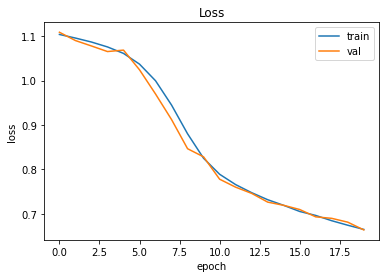

In [60]:
from matplotlib import pyplot
pyplot.plot(new_model_1_obj.history['loss'])
pyplot.plot(new_model_1_obj.history['val_loss'])
pyplot.title("Loss")
pyplot.ylabel("loss")
pyplot.xlabel("epoch")
pyplot.legend(['train', 'val'], loc='upper right')
pyplot.show()

* From the above loss graph, validation loss didn't reduce throughout and is increased at some points whereas training loss reduced till 20 epochs. 
* That is, the model performed well on train set but not on test set(validation dataset here) and hence the model has overfit the training data.
* Making further modifications in the architecture and/or parameters.

In [61]:
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

#y_pred_class = model.predict_classes(test_x, verbose=0)
#y_test_class = np.argmax(test_y, axis=1)
#print(classification_report(y_test_class, y_pred_class))

### Implementation 2 

In [62]:
model_2=Sequential()
model_2.add(Dense(1000,input_dim=51,activation='relu'))
model_2.add(Dense(500,activation='relu'))
model_2.add(Dense(300,activation='relu'))
model_2.add(Dense(3,activation='softmax'))
model_2.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

In [63]:
start_time = time.time()
model_2_obj=model_2.fit(train_valid_x, train_valid_y, epochs=20, shuffle=True, validation_split=0.1111)
elapsed_time = time.time() - start_time

Epoch 1/20
372/372 [==============================] - 2s 4ms/step - loss: 0.9256 - accuracy: 0.6001 - val_loss: 0.6292 - val_accuracy: 0.7685
Epoch 2/20
372/372 [==============================] - 1s 4ms/step - loss: 0.5711 - accuracy: 0.7904 - val_loss: 0.4587 - val_accuracy: 0.8291
Epoch 3/20
372/372 [==============================] - 1s 4ms/step - loss: 0.4294 - accuracy: 0.8435 - val_loss: 0.3821 - val_accuracy: 0.8668
Epoch 4/20
372/372 [==============================] - 1s 4ms/step - loss: 0.3641 - accuracy: 0.8728 - val_loss: 0.3464 - val_accuracy: 0.8627
Epoch 5/20
372/372 [==============================] - 2s 4ms/step - loss: 0.3278 - accuracy: 0.8840 - val_loss: 0.3483 - val_accuracy: 0.8647
Epoch 6/20
372/372 [==============================] - 1s 4ms/step - loss: 0.3190 - accuracy: 0.8904 - val_loss: 0.3190 - val_accuracy: 0.8910
Epoch 7/20
372/372 [==============================] - 1s 4ms/step - loss: 0.3231 - accuracy: 0.8907 - val_loss: 0.3007 - val_accuracy: 0.8910
Epoch 

In [64]:
print("Time taken for the training (in seconds): {}".format(elapsed_time))

Time taken for the training (in seconds): 30.28716468811035


In [65]:
start_time = time.time()
test_loss, test_accuracy = model_2.evaluate(test_x, test_y)
elapsed_time = time.time() - start_time

47/47 [==============================] - 0s 1ms/step - loss: 0.2845 - accuracy: 0.8964


In [66]:
print("Time taken for the testing (in seconds): {}".format(elapsed_time))

Time taken for the testing (in seconds): 0.10919952392578125


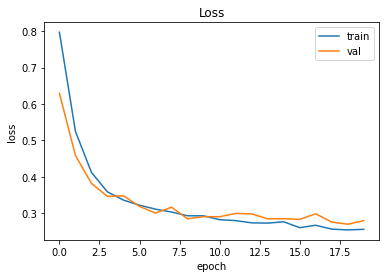

In [67]:
pyplot.plot(model_2_obj.history['loss'])
pyplot.plot(model_2_obj.history['val_loss'])
pyplot.title("Loss")
pyplot.ylabel("loss")
pyplot.xlabel("epoch")
pyplot.legend(['train', 'val'], loc='upper right')
pyplot.show()

* In the second implementation, activation function has been changed to see if there will be any change in the way the model performs. Yes we can see a change, compared to the previous model, this new model 2 has loss graph even more smoother. Compare the loss graphs of implementation 1 and 2 and it is evident.
* validation loss didn't reduce throughout and is increased at some points. 
* Model is considered to be overfit if training loss is reduced but the test loss increased, that is, the model performed well on train set but not on test set. Hence regularization techniques are further implemented within the model to avoid overfitting.

### Implementation 3 (Introducing Regularization in the architecture)

In [68]:
model_3=Sequential()
model_3.add(Dense(1000,input_dim=51,activation='relu'))
model_3.add(Dense(500,activation='relu'))
model_3.add(Dense(300,activation='relu',kernel_regularizer=keras.regularizers.l1(0.01)))
model_3.add(Dense(3,activation='softmax'))
model_3.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
start_time = time.time()
model_3_obj=model_3.fit(train_valid_x, train_valid_y, epochs=20, shuffle=True, validation_split=0.1111)
elapsed_time = time.time() - start_time

Epoch 1/20
372/372 [==============================] - 2s 4ms/step - loss: 4.5255 - accuracy: 0.6085 - val_loss: 3.8693 - val_accuracy: 0.7645
Epoch 2/20
372/372 [==============================] - 1s 4ms/step - loss: 3.6983 - accuracy: 0.7911 - val_loss: 3.2692 - val_accuracy: 0.8183
Epoch 3/20
372/372 [==============================] - 1s 4ms/step - loss: 3.1415 - accuracy: 0.8404 - val_loss: 2.8157 - val_accuracy: 0.8688
Epoch 4/20
372/372 [==============================] - 1s 4ms/step - loss: 2.7087 - accuracy: 0.8672 - val_loss: 2.4497 - val_accuracy: 0.8614
Epoch 5/20
372/372 [==============================] - 2s 4ms/step - loss: 2.3523 - accuracy: 0.8828 - val_loss: 2.1599 - val_accuracy: 0.8641
Epoch 6/20
372/372 [==============================] - 2s 4ms/step - loss: 2.0699 - accuracy: 0.8880 - val_loss: 1.8816 - val_accuracy: 0.8910
Epoch 7/20
372/372 [==============================] - 2s 4ms/step - loss: 1.8277 - accuracy: 0.8885 - val_loss: 1.6499 - val_accuracy: 0.8923
Epoch 

In [69]:
print("Time taken for the training (in seconds): {}".format(elapsed_time))

Time taken for the training (in seconds): 30.888737201690674


In [70]:
start_time = time.time()
test_loss, test_accuracy = model_3.evaluate(test_x, test_y)
elapsed_time = time.time() - start_time

47/47 [==============================] - 0s 1ms/step - loss: 0.4888 - accuracy: 0.8957


In [71]:
print("Time taken for the testing (in seconds): {}".format(elapsed_time))

Time taken for the testing (in seconds): 0.09764480590820312


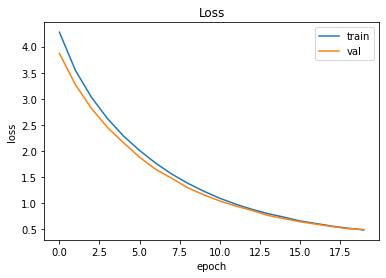

In [72]:
pyplot.plot(model_3_obj.history['loss'])
pyplot.plot(model_3_obj.history['val_loss'])
pyplot.title("Loss")
pyplot.ylabel("loss")
pyplot.xlabel("epoch")
pyplot.legend(['train', 'val'], loc='upper right')
pyplot.show()

* Regularization technique - L2 was introduced here and it has performed really well in preventing the overfit.

* We have used L2 regularization (Sum of the squared weights) with hyperparameter value 0.01. This adds a penalty for weight size to the loss function and reduces overfitting.

* From the above plot we see that training loss decreased gradually till 20th epoch, the validation loss also decreased throughout and has a small margin with the training loss. The plot shows a good fit.

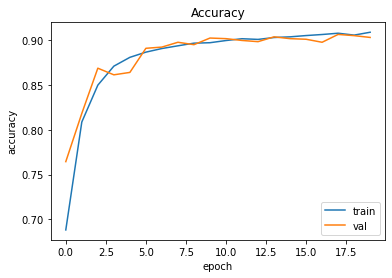

In [73]:
pyplot.plot(model_3_obj.history['accuracy'])
pyplot.plot(model_3_obj.history['val_accuracy'])
pyplot.title("Accuracy")
pyplot.ylabel("accuracy")
pyplot.xlabel("epoch")
pyplot.legend(['train', 'val'], loc='lower right')
pyplot.show()

* Above is the plot for train and Val accurcies vs Number of Epochs.
* Accuracy has improved right from 70 till 91% and from the graph it can be inferred that the model has improved better compared to other implementations.
* This model has been considered final at this point. LSTM is implemented after this and it is compared later to check iot's performance.

###  Implementation 4 : LSTM

In [74]:
from keras.layers import LSTM
import numpy as np
from sklearn import preprocessing

In [75]:
target=["Outcome1"]
cols=[col for col in dataset.columns if col not in target]

x=dataset[cols]
y=dataset[target]

In [76]:
norm_x=x.copy()
scale = StandardScaler()
columns_to_scale = ['Age_Group','Reporting_PHU_Latitude', 'Reporting_PHU_Longitude']
norm_x[columns_to_scale] = scale.fit_transform(norm_x[columns_to_scale])

y2=dataset[target]
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
y["Outcome1"]= label_encoder.fit_transform(y["Outcome1"])

In [77]:
#splitting the dataset into train, test and using train for cross validation

x_train_val, x_test, y_train_val, y_test = train_test_split(norm_x, y, test_size = 0.2, random_state = 275)
train_x,valid_x,train_y,valid_y=train_test_split(x_train_val, y_train_val, test_size=0.1111, random_state=275)

train_x, train_y = np.array(train_x), np.array(train_y)
x_test, y_test = np.array(x_test), np.array(y_test)
valid_x, valid_y = np.array(valid_x), np.array(valid_y)

train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
valid_x = np.reshape(valid_x, (valid_x.shape[0], valid_x.shape[1], 1))

In [78]:
train_x.shape,x_test.shape,valid_x.shape

((10567, 51, 1), (2972, 51, 1), (1321, 51, 1))

In [79]:
deep_model_lstm = Sequential()
deep_model_lstm.add(LSTM(units = 200, return_sequences = True, input_shape = (train_x.shape[1], 1)))
deep_model_lstm.add(Dropout(0.2))
deep_model_lstm.add(LSTM(units = 200, return_sequences = False))
deep_model_lstm.add(Dense(3, activation='softmax'))

deep_model_lstm.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history_lstm = deep_model_lstm.fit(train_x, train_y, epochs=100,validation_data=(valid_x,valid_y),batch_size=1000)
elapsed_time = time.time() - start_time

Epoch 1/100
11/11 [==============================] - 23s 2s/step - loss: 1.0981 - accuracy: 0.3529 - val_loss: 1.0906 - val_accuracy: 0.3202
Epoch 2/100
11/11 [==============================] - 19s 2s/step - loss: 1.0948 - accuracy: 0.3351 - val_loss: 1.0922 - val_accuracy: 0.3588
Epoch 3/100
11/11 [==============================] - 19s 2s/step - loss: 1.0918 - accuracy: 0.3671 - val_loss: 1.0825 - val_accuracy: 0.3997
Epoch 4/100
11/11 [==============================] - 19s 2s/step - loss: 1.0939 - accuracy: 0.4050 - val_loss: 1.0884 - val_accuracy: 0.3460
Epoch 5/100
11/11 [==============================] - 19s 2s/step - loss: 1.0871 - accuracy: 0.4039 - val_loss: 1.0866 - val_accuracy: 0.3906
Epoch 6/100
11/11 [==============================] - 19s 2s/step - loss: 1.0858 - accuracy: 0.3918 - val_loss: 1.0775 - val_accuracy: 0.4807
Epoch 7/100
11/11 [==============================] - 19s 2s/step - loss: 1.0485 - accuracy: 0.4944 - val_loss: 1.5474 - val_accuracy: 0.3270
Epoch 8/100
1

Epoch 59/100
11/11 [==============================] - 19s 2s/step - loss: 0.7375 - accuracy: 0.6129 - val_loss: 0.7424 - val_accuracy: 0.6109
Epoch 60/100
11/11 [==============================] - 19s 2s/step - loss: 0.7376 - accuracy: 0.6053 - val_loss: 0.7374 - val_accuracy: 0.6200
Epoch 61/100
11/11 [==============================] - 19s 2s/step - loss: 0.7367 - accuracy: 0.6043 - val_loss: 0.7393 - val_accuracy: 0.6064
Epoch 62/100
11/11 [==============================] - 19s 2s/step - loss: 0.7294 - accuracy: 0.6193 - val_loss: 0.7405 - val_accuracy: 0.6071
Epoch 63/100
11/11 [==============================] - 19s 2s/step - loss: 0.7355 - accuracy: 0.6035 - val_loss: 0.7408 - val_accuracy: 0.5935
Epoch 64/100
11/11 [==============================] - 19s 2s/step - loss: 0.7417 - accuracy: 0.5966 - val_loss: 0.7433 - val_accuracy: 0.6139
Epoch 65/100
11/11 [==============================] - 19s 2s/step - loss: 0.7412 - accuracy: 0.6128 - val_loss: 0.7445 - val_accuracy: 0.6147
Epoch 

In [80]:
print("Time taken for the training (in seconds): {}".format(elapsed_time))

Time taken for the training (in seconds): 1890.8388817310333


In [81]:
start_time = time.time()
test_loss, test_accuracy = deep_model_lstm.evaluate(x_test, y_test)
elapsed_time = time.time() - start_time

93/93 [==============================] - 4s 27ms/step - loss: 0.7121 - accuracy: 0.6491


In [82]:
print("Time taken for the testing (in seconds): {}".format(elapsed_time))

Time taken for the testing (in seconds): 4.206311225891113


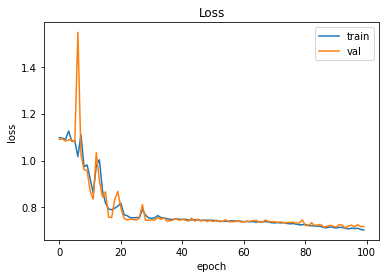

In [83]:
pyplot.plot(history_lstm.history['loss'])
pyplot.plot(history_lstm.history['val_loss'])
pyplot.title("Loss")
pyplot.ylabel("loss")
pyplot.xlabel("epoch")
pyplot.legend(['train', 'val'], loc='upper right')
pyplot.show()

In [84]:
deep_model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 51, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 51, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 603       
Total params: 483,003
Trainable params: 483,003
Non-trainable params: 0
_________________________________________________________________


##### Summary of LSTM implementation
* We are using sequential API, a linear stack of layers. Each layer is added sequentially now on to this model.
* A LSTM layer with 200 units (dimensionality of the output space) is added as first layer.
* A dropout layer follows the LSTM layer, this will prevent the overfit.
* Another LSTM layer has been added after the dropoyt layer.
* A dense layer with a softmax function for the output has been added as the last layer which outputs three classes

#### Final model details
* A total of 4 implementations were tried, out of these third implementation which is a fully connected neural network has performed well compared to all other models.
* LSTM in this case has not performed well with the chosen parameters compared to a fully connected neural net. 
* Proceeding with the FNN as the final model
* It has a good fit over the dataset and the plots between loss vs epoch and accuracy vs epochs clearly shows the performance.
* The training accuracy was 90.94% and test accuracy was 89.57%.
* There is no overfit on the data (inferred from the graphs).
* The architecture of the final model is plotted and discussed below.

### Model Architecture

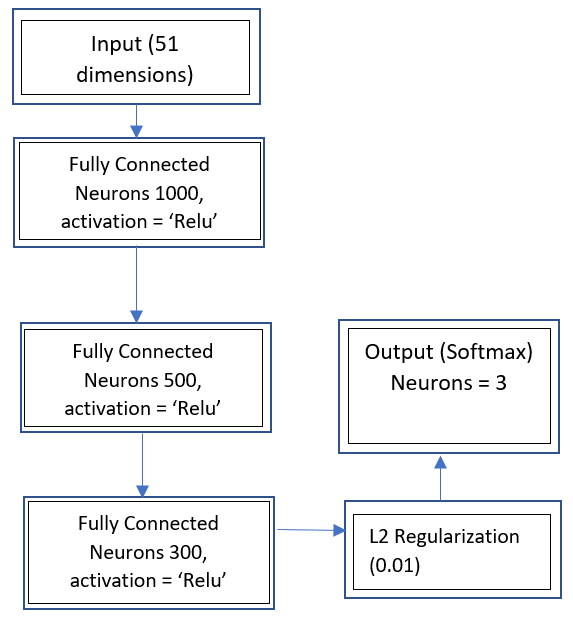

### Model Description

* We are using sequential API, a linear stack of layers. Each layer is added sequentially now on to this model.
* We have fully connected layers with activation function as "Relu", which are the building blocks of the DNN.
* Regularization - L2 regularization is used to avoid overfitting

* Our input is first passed over three dense layers and Then it is passed over regularization layer with l2 regularization( hyperparameter value 0.01).
* Last output layer is a dense layer with softmax activation that classifies 3 categories of data in the given in COVID dataset.

### 1.2 [CM2] : Implementation Details

* We first started with a basic architecture for a neural network and it has not performed that well. It has overfit the data at many points. Sigmoid function was used as the activation function and the train, validation loss vs epoch graph is not that smoother and has got spikes in between.

* The second implementation had Relu as the activation function and this function seem to work universally better and the same can be seen from the loss graphs plotted above. Loss graphs are now smoother and there is overfit after 10 epochs. So still the architecture has to be modified and improved.


* The third implementation also has Relu as the activation function in it's connected layers as this has performed well in second implementation. For reducing the overfit, "Dropout" technique was not used because a fully connected neural net was asked in the assignment and dropout would actually leave out neurons during the propagation. Hence, L2 regularization was used. Loss and accuracy plots seem to be good and it shows there is no overfit. 

* LSTM was also implemented but in our case, the third implementation produced better results and hence we are considering it.

* The dataset is normalized using standard scalar and then is fed to neural networks.


In [85]:
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1000)              52000     
_________________________________________________________________
dense_22 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_23 (Dense)             (None, 300)               150300    
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 903       
Total params: 703,703
Trainable params: 703,703
Non-trainable params: 0
_________________________________________________________________


* Above is the final architecture summary
* It consists of sequential block over which 3 dense layers, with 1000,500,300 units are added  and all these are fully connected. Last layer is a output layer with softmax function that outputs three classes.

model.add(Dense(300,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))

The above code block is critical to our model with regularization and this is the layer where most of the computation happen additionally compared to others because of the introduced extra parameter.

### 1.3 [CM3] : Results Analysis

### Run time perfomance for tranining and testing

##### The final model has been run without the GPU as it is a simple FNN.
##### Time taken for training and testing are reported below

|  | Trained on(samples) | Tested on(samples) | Training time(seconds) | Classification time(on test data)(seconds) |
| :- | :- | :- | :- | :- |
| Without GPU | 11,888 | 1486 | 30.88 | 0.097 |


The above table clearly shows the number of sample the model trained on and number of models the model tested and time taken for train and classification.

1. The time taken by our final DNN model for training is 30.88 sec. Whereas the time taken for the model to test (from the time input is fed to the time we obtain the model decision) is 0.097 sec

2. The time taken by our DNN model without regularization and activation function as "sigmoid" for training is 30.19 sec. Whereas the time taken for the model to test (from the time input is fed to the time we obtain the model decision) is 0.11 sec

3. The time taken by our DNN model without regularization and activation function as "relu" for training is 30.28 sec. Whereas the time taken for the model to test (from the time input is fed to the time we obtain the model decision) is 0.12 sec

4. LSTM has taken 1890 secs for training.

Comparision of different deep learning algorithms and parameters was already mentioned in the above sections, but re-writing them here to answer [CM3]

* We first started with a basic architecture for a neural network and it has not performed that well. It has overfit the data at many points. Sigmoid function was used as the activation function and the train, validation loss vs epoch graph is not that smoother and has got spikes in between.

* The second implementation had Relu as the activation function and this function seem to work universally better and the same can be seen from the loss graphs plotted above. Loss graphs are now smoother and there is overfit after 10 epochs. So still the architecture has to be modified and improved.

* The third implementation also has Relu as the activation function in it's connected layers as this has performed well in second implementation. For reducing the overfit, "Dropout" technique was not used because a fully connected neural net was asked in the assignment and dropout would actually leave out neurons during the propagation. Hence, L2 regularization was used. Loss and accuracy plots seem to be good and it shows there is no overfit. 

* LSTM was also implemented but in our case, the third implementation produced better results and hence we are considering it.


* We tried with different optimizers like Adam, SGD and Stochastic Gradient Descent helped the model to better generalize the data and prevented overfit.
* Activation functions like Relu, sigmoid were also tried and Relu gave better results.

* We modified number of epochs also and have chosen 20 as optimal one so as to not let the model overfit the data.

* Different batch_sizes were also tried and the size 32 seem to give better accuracy.

##### Plots to analyze the model better

* Training epochs vs Loss

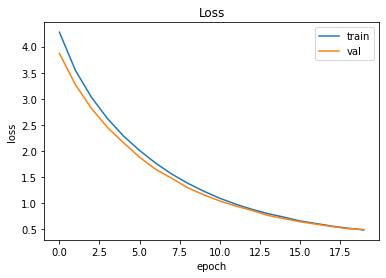

In [86]:
pyplot.plot(model_3_obj.history['loss'])
pyplot.plot(model_3_obj.history['val_loss'])
pyplot.title("Loss")
pyplot.ylabel("loss")
pyplot.xlabel("epoch")
pyplot.legend(['train', 'val'], loc='upper right')
pyplot.show()

* Classification accuracy vs Loss

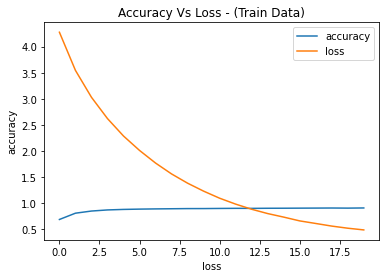

In [87]:
pyplot.plot(model_3_obj.history['accuracy'])
pyplot.plot(model_3_obj.history['loss'])
pyplot.title("Accuracy Vs Loss - (Train Data)")
pyplot.ylabel("accuracy")
pyplot.xlabel("loss")
pyplot.legend(['accuracy', 'loss'], loc='upper right')
pyplot.show()

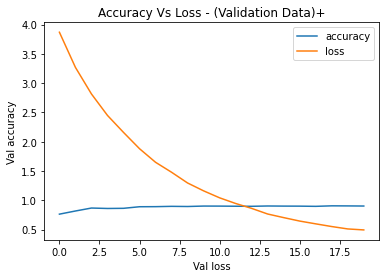

In [88]:
pyplot.plot(model_3_obj.history['val_accuracy'])
pyplot.plot(model_3_obj.history['val_loss'])
pyplot.title("Accuracy Vs Loss - (Validation Data)+")
pyplot.ylabel("Val accuracy")
pyplot.xlabel("Val loss")
pyplot.legend(['accuracy', 'loss'], loc='upper right')
pyplot.show()

From the Epochs vs Loss plot, one can notice that the loss reduced as number of epochs increased and there is clearly no overfit. Various methods like regularization, change in optimizers, optimal number of hidden layers, epochs helped in reducing the overfit.

Accuracy vs Loss plot on validation data shows that the model performed well (started from 60% and increased to 91%).

The model on test data gave an classification accuracy of 89.57%

In [97]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    pyplot.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

rounded_labels=np.argmax(test_y, axis=1)
(unique, counts) = np.unique(rounded_labels, return_counts=True)
frequencies = np.asarray((unique, counts))
print(frequencies)


[[  0   1   2]
 [501 490 495]]


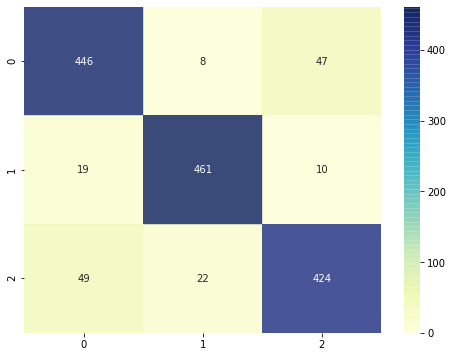

In [98]:
plot_confusion_matrix(model_3, test_x, rounded_labels)

##### Analyzing the confusion matrix
* The final model was able to identify 446 Fatal cases correctly. Only 10% of the samples were wrongly identified. 
* Out of 490 samples which have target 1 (Not Resolved), 461 were correctly identified which means only 5.9% of samples were wrongly classified.
* ALso, total samples of target as 2 are 495 and out of these 495, 424 were correctly identified. Which means 15% are wrongly identified.

* This clearly shows that our model identifies the targets well and the error percentage is less than 15%.

#### 1.4: Kaggle Competition Score

##### Participated on Kaggle and have submitted the predictions too. Please refer to Asg4-Grp 4 on Kaggle and also the corresponding python notebook was uploaded on Learn for reference.

#### Blogs, websites referred

https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html

https://towardsdatascience.com/neural-network-optimization-7ca72d4db3e0

https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/code

https://www.kaggle.com/louisong97/neural-network-approach-to-iris-dataset

